### Node based encoding

In [153]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [154]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader
from GDa.session import session_info
from GDa.util import shuffle_along_axis

##### Setting configurations

In [155]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [156]:
metric = "coh"
monkey = "ethyl"
ds = 1

In [157]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [158]:
sessions = get_dates(monkey)

In [159]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [160]:
stages = [[-0.6, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [161]:
bands = [[0, 8], [8, 21], [21, 32], [32, 80]]
band_names = ["theta", "alpha", "beta", "gamma"]

In [162]:
path = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/power")

In [163]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [164]:
p_crk = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path, "pval_crackle_1_br_1_aligned_cue_q_90_fdr.nc"))
)
t_crk = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path, "tval_crackle_1_br_1_aligned_cue_q_90_fdr.nc"))
)

In [165]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
idx = np.argsort(regions)

In [166]:
t_pow = t_pow * (p_pow <= 0.001)
t_crk = t_crk * (p_crk <= 0.001)

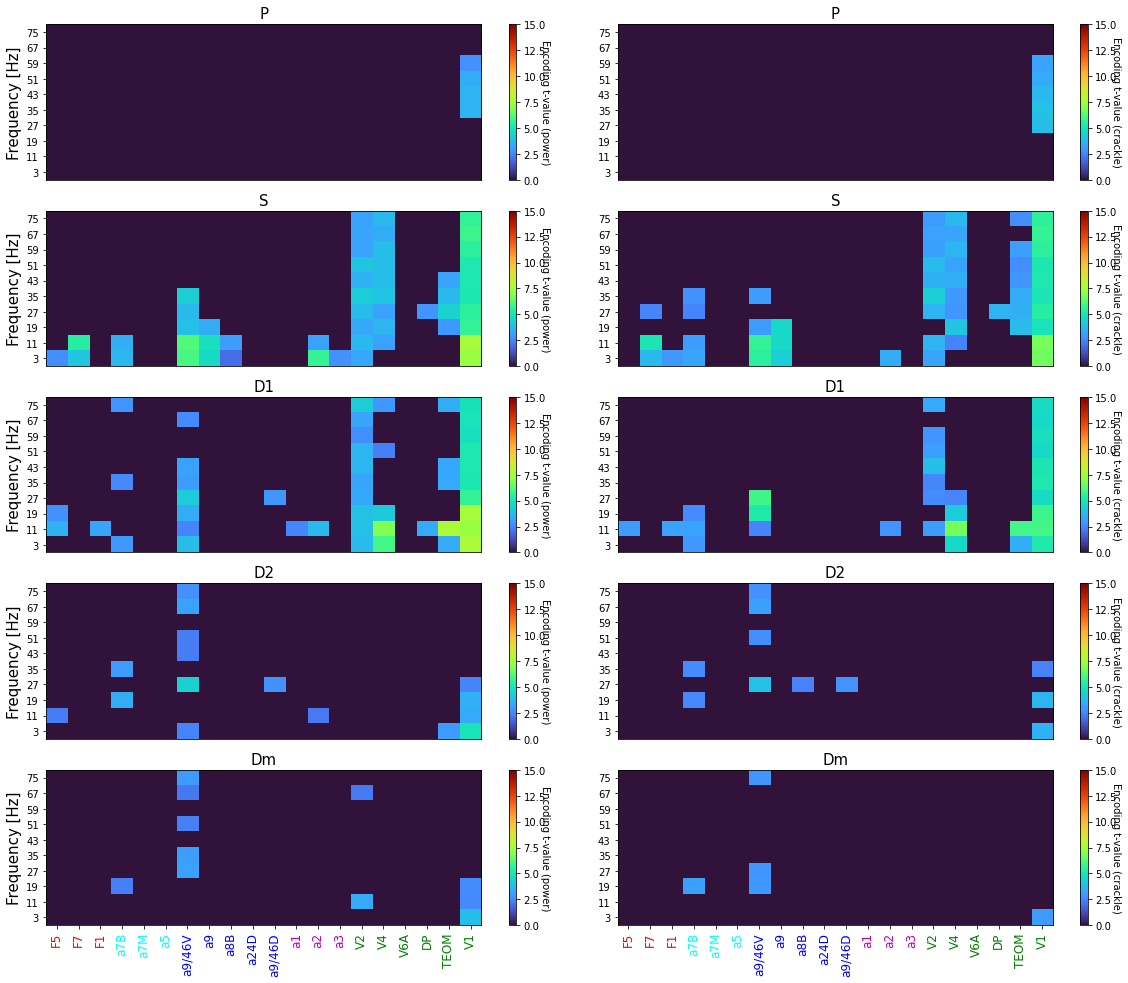

In [26]:
plt.figure(figsize=(20, 20))
pos = 1
for i in range(0, 5):
    # Power
    plt.subplot(6, 2, pos)
    plt.imshow(
        t_pow.sel(times=i).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 4:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=12
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    else:
        plt.xticks([])
    plt.yticks(range(10), p_pow.freqs.data.astype(int))
    plt.ylabel("Frequency [Hz]", fontsize=15)
    plt.title(f"{stage_labels[i]}", fontsize=15)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Encoding t-value (power)", rotation=270)
    pos = pos + 1
    # Crackle
    plt.subplot(6, 2, pos)
    plt.imshow(
        t_crk.sel(times=i).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 4:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=12
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    else:
        plt.xticks([])
    plt.yticks(range(10), p_pow.freqs.data.astype(int))
    plt.title(f"{stage_labels[i]}", fontsize=15)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Encoding t-value (crackle)", rotation=270)
    pos = pos + 1
plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/n2/power_encoding_ethyl.pdf", bbox_inches="tight")

In [27]:
import argparse
import os

import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from tqdm import tqdm

from config import get_dates, return_delay_split
from GDa.util import average_stages

In [28]:
def mi_visual_subsample(roi="V1", nboots=100, slvr_only=True):
    tt = 1
    br = 1
    at = "cue"
    avg = True

    sxx = []
    stim = []
    for s_id in tqdm(sessions):
        _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
        path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
        power = xr.load_dataarray(path_pow)
        rois = power.roi.data
        attrs = power.attrs
        sel_idx = rois == roi
        # Remove SLVR channels if slvr_only=False
        info = session_info(
            raw_path=os.path.join(_ROOT, "GrayLab"),
            monkey=monkey,
            date=s_id,
            session=1,
        )
        slvr_idx = info.recording_info["slvr"].astype(bool)
        if not bool(slvr_only):
            sel_idx = np.logical_and(np.logical_not(slvr_idx), sel_idx)
        else:
            sel_idx = np.logical_and(slvr_idx, sel_idx)

        power = power.isel(roi=sel_idx)

        # Averages power for each period (baseline, cue, delay, match) if needed
        # out = average_stages(power, avg, early_cue=early_cue,
        # early_delay=early_delay)
        # Average epochs
        out = []
        if avg:
            for t0, t1 in stages:
                out += [power.sel(times=slice(t0, t1)).mean("times")]
            out = xr.concat(out, "times")
            out = out.transpose("trials", "roi", "freqs", "times")
        else:
            out = power
        out.attrs = attrs
        sxx += [out.isel(roi=[r]) for r in range(len(out["roi"]))]
        stim += [out.attrs["stim"].astype(int)] * len(out["roi"])

    mis = []
    pvals = []
    for boot in tqdm(range(nboots)):

        # Subsample indexes
        idx = np.random.choice(range(len(sxx)), size=20, replace=False)

        sxx_ = [sxx[i] for i in idx]
        stim_ = [stim[i] for i in idx]

        # Convert to DatasetEphy
        dt = DatasetEphy(sxx_, y=stim_, nb_min_suj=10, times="times", roi="roi")

        mi_type = "cd"
        inference = "rfx"
        kernel = None

        if avg:
            mcp = "fdr"
        else:
            mcp = "cluster"

        mi_type = "cd"

        estimator = GCMIEstimator(
            mi_type="cd",
            copnorm=True,
            biascorrect=True,
            demeaned=False,
            tensor=True,
            gpu=False,
            verbose=False,
        )
        wf = WfMi(mi_type, inference, verbose=False, kernel=kernel, estimator=estimator)

        kw = dict(n_jobs=30, n_perm=200)
        cluster_th = None

        mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)
        mis += [mi]
        pvals += [pvalues]

    alpha = 0.001
    df = xr.concat(pvals, "boot").squeeze()
    return confidence_interval((df < alpha).astype(int), axis=0).squeeze()

In [29]:
ci_v1 = mi_visual_subsample(roi="V1", nboots=100, slvr_only=False)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:04<07:39,  4.64s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:06<05:16,  3.23s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:08<04:19,  2.67s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:10<03:50,  2.40s/it]Definition of an electrophysiological

In [30]:
ci_v1_noslvr = mi_visual_subsample(roi="V1", nboots=100, slvr_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:01<03:10,  1.92s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:03<03:08,  1.92s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:05<03:10,  1.97s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:07<03:09,  1.97s/it]Definition of an electrophysiological

In [31]:
ci_v2 = mi_visual_subsample(roi="V2", nboots=100, slvr_only=False)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:02<03:19,  2.01s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:03<03:10,  1.94s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:05<03:10,  1.96s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:07<03:13,  2.02s/it]Definition of an electrophysiological

In [32]:
ci_v2_noslvr = mi_visual_subsample(roi="V2", nboots=100, slvr_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [33]:
data_loader = loader(_ROOT=_ROOT)

kw_loader = dict(
    session="110718", aligned_at="cue", channel_numbers=False, monkey=monkey
)

power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

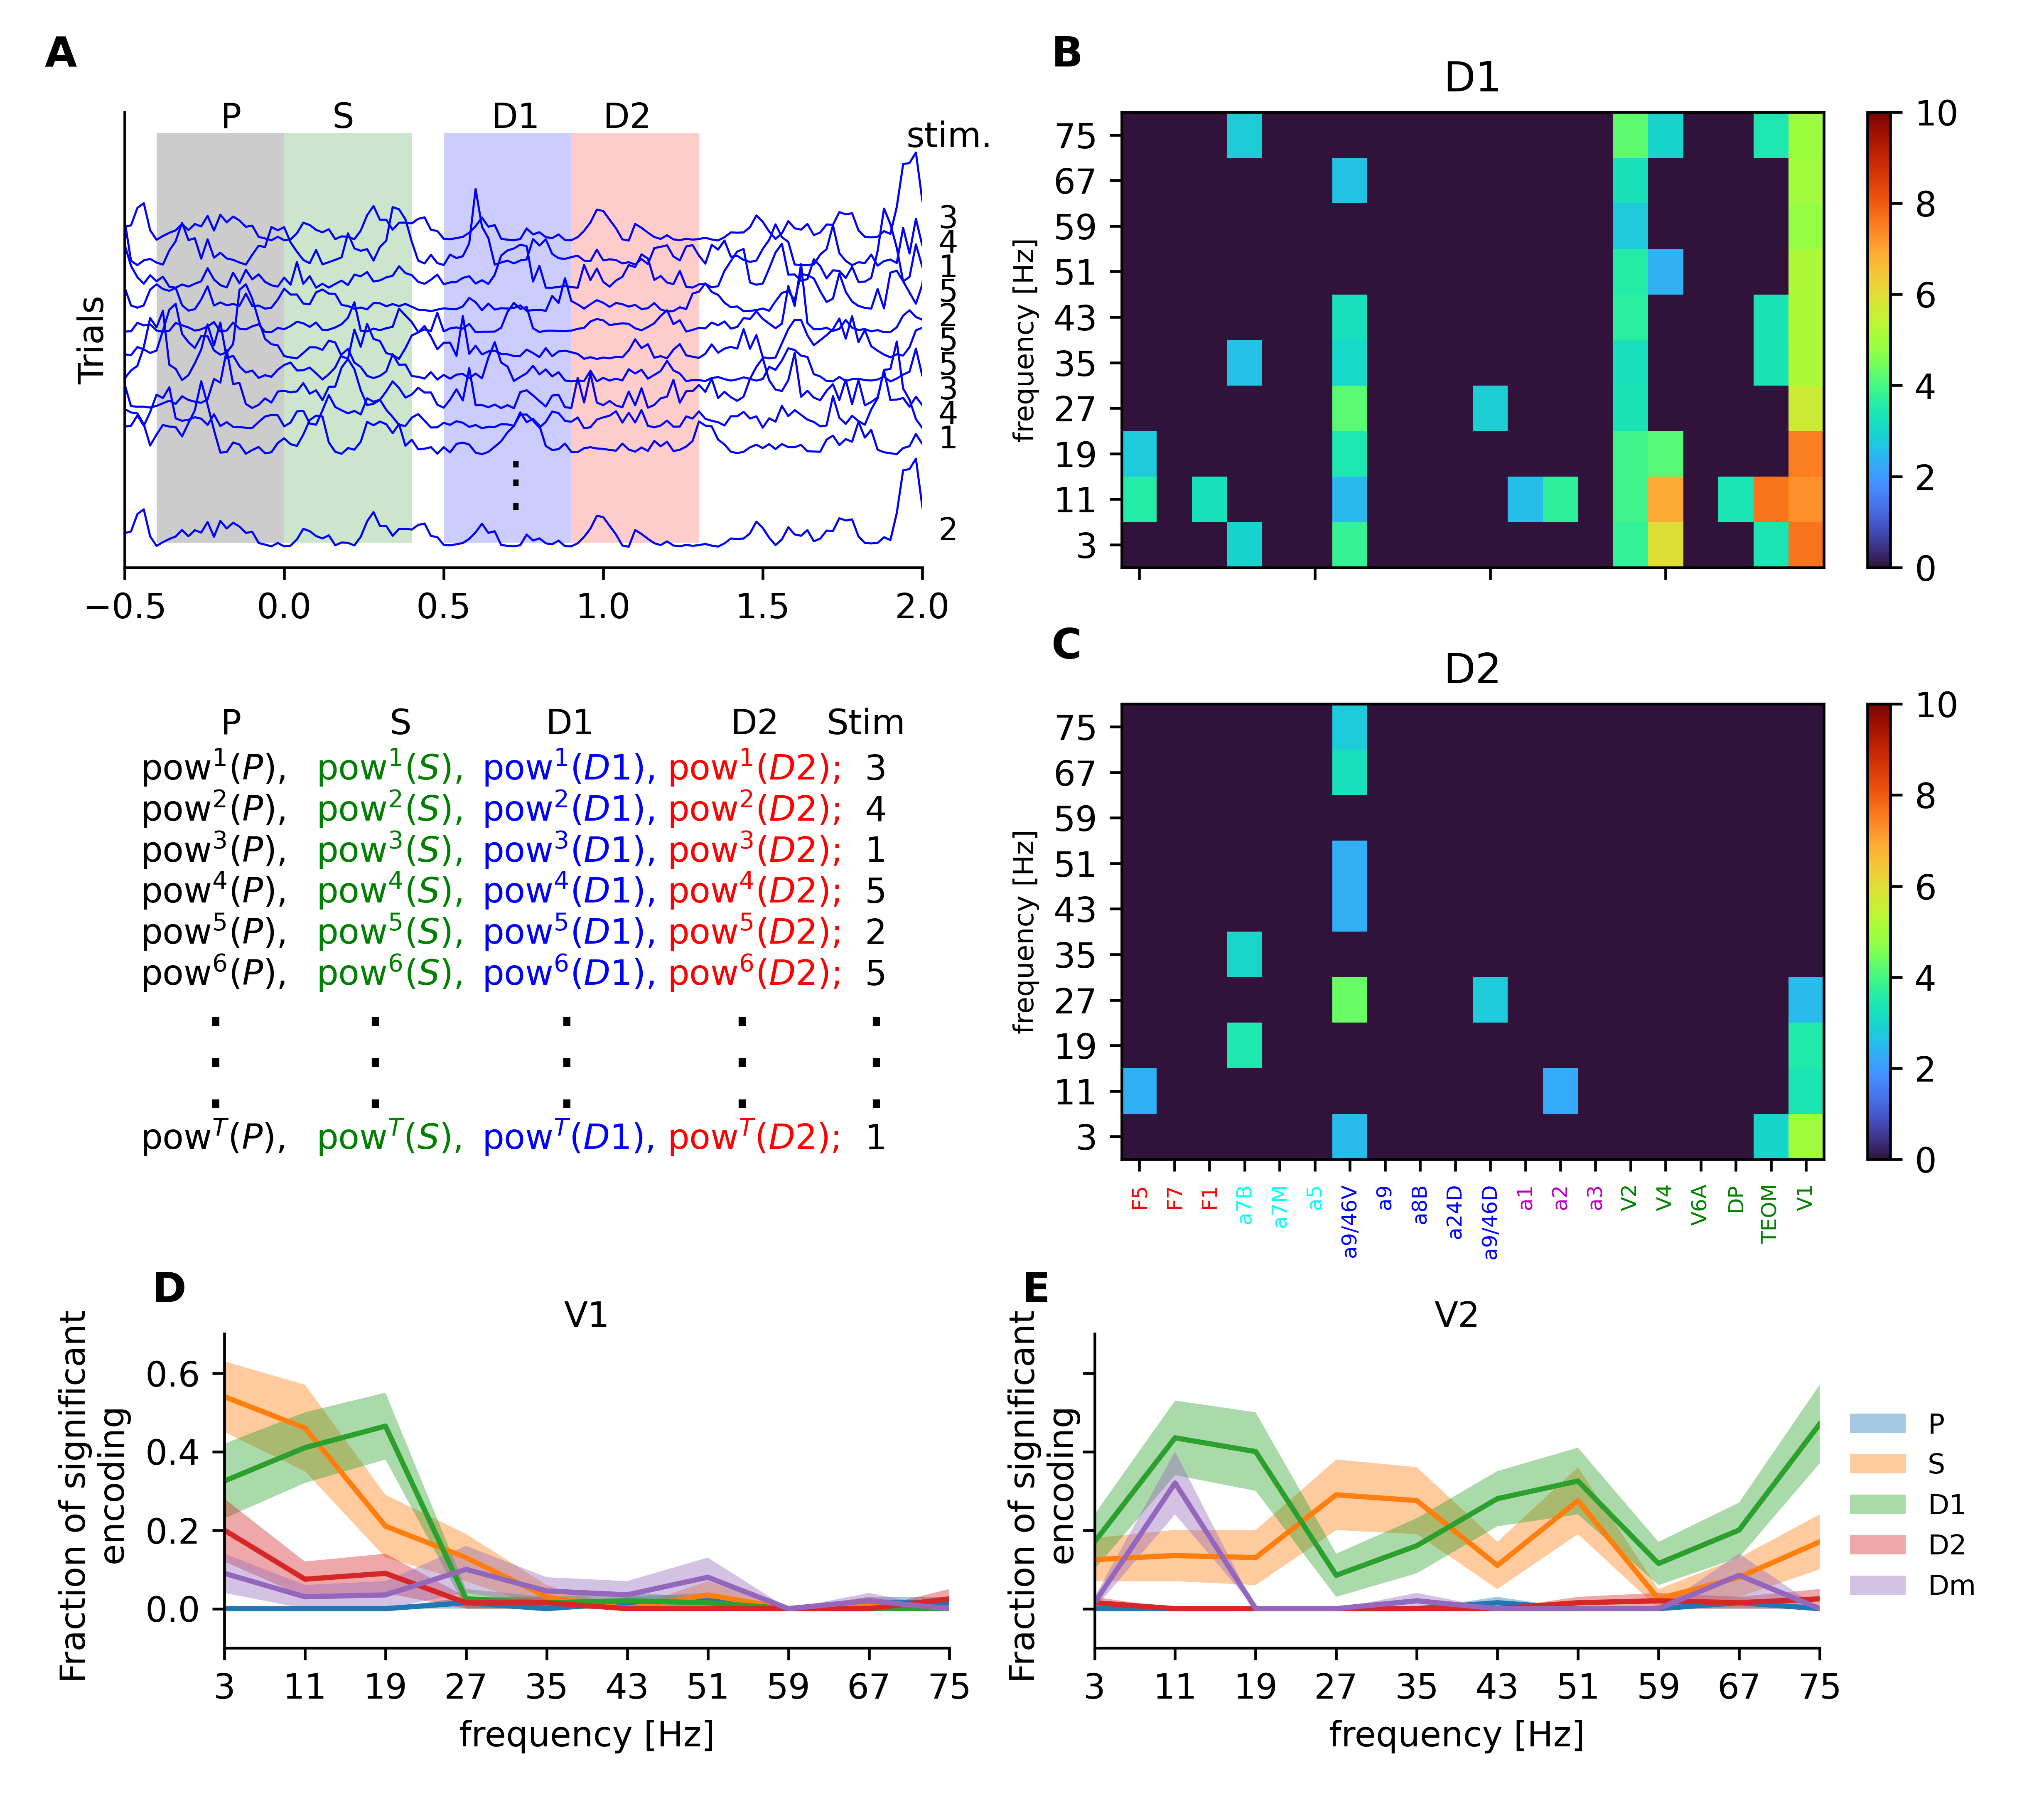

In [42]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 7), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.05,
    right=0.45,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs1 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.55,
    right=0.99,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.1,
    right=0.90,
    hspace=0.3,
    bottom=0.07,
    top=0.25,
)

axs0 = [plt.subplot(gs0[i]) for i in range(2)]

plt.sca(axs0[0])
v1ts = power_task.isel(roi=0).sel(freqs=27)
v1ts = (v1ts - v1ts.mean("times")) / v1ts.std("times")
times = v1ts.times.data

stims = np.random.randint(1, 6, 11)

for i in range(10):
    plt.plot(times, 3 * v1ts.isel(trials=i) + 5 * i, color="b", lw=0.6)
    plt.text(2.05, 5.2 * i - 2, f"{stims[i]}", fontsize=9)

plt.plot(times, 3 * v1ts.isel(trials=i) - 20, color="b", lw=0.6)
plt.text(2.05, -21.5, f"{stims[-1]}", fontsize=9)
plt.text(0.7, -15, ".", fontsize=15)
plt.text(0.7, -10, ".", fontsize=15)
plt.text(0.7, -6, ".", fontsize=15)
plt.text(1.95, 62, "stim.")
plt.xlim(-0.5, 2)

rP = Rectangle(
    (-0.4, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="k", alpha=0.2
)
rS = Rectangle(
    (0, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="g", alpha=0.2
)
rD1 = Rectangle(
    (0.5, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="b", alpha=0.2
)
rD2 = Rectangle(
    (0.9, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="r", alpha=0.2
)


axs0[0].add_patch(rP)
plt.text(-0.2, 66, "P")
axs0[0].add_patch(rS)
plt.text(0.15, 66, "S")
axs0[0].add_patch(rD1)
plt.text(0.65, 66, "D1")
axs0[0].add_patch(rD2)
plt.text(1.0, 66, "D2")


[axs0[0].spines[key].set_visible(False) for key in ["top", "right"]]
plt.yticks([])
plt.ylabel("Trials")

plt.sca(axs0[1])
plt.ylim(0, 90)
plt.xlim(-0.5, 2)


plt.text(-0.2, 84, "P")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(-0.25, xpos, ".", fontsize=20)
        continue
    plt.text(-0.45, xpos, f"pow$^{exp}(P)$,")

plt.text(0.33, 84, "S")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.25, xpos, ".", fontsize=20)
        continue
    plt.text(0.1, xpos, f"pow$^{exp}(S)$,", color="g")


plt.text(0.82, 84, "D1")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.85, xpos, ".", fontsize=20)
        continue
    plt.text(0.62, xpos, f"pow$^{exp}(D1)$,", color="b")

plt.text(1.4, 84, "D2")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.4, xpos, ".", fontsize=20)
        continue
    plt.text(1.2, xpos, f"pow$^{exp}(D2)$;", color="r")

plt.text(1.7, 84, "Stim")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.82, xpos, ".", fontsize=20)
        continue
    plt.text(1.82, xpos, f"{stims[i]}")
plt.axis("off")

axs1 = [plt.subplot(gs1[i]) for i in range(2)]

for i in range(2):
    plt.sca(axs1[i])
    plt.imshow(
        t_pow.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=10,
        cmap="turbo",
        origin="lower",
    )
    if i == 1:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.ylabel("frequency [Hz]", fontsize=8)
    cbar = plt.colorbar()
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs1[0].get_xticklabels(), visible=False)


axs2 = [plt.subplot(gs2[i]) for i in range(2)]

ci = [ci_v1, ci_v2]
for pos in range(2):
    plt.sca(axs2[pos])
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        axs2[pos].legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.ylim(-0.1, 0.7)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [axs2[pos].spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(axs2[1].get_yticklabels(), visible=False)


plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs1[0], axs1[1], axs2[0], axs2[1]],
    fontsize=12,
    xpos=[-0.1, -0.1, -0.1, -0.1, -0.1],
    ypos=[1.1, 1.1, 1.1, 1.1, 1.1],
)

bg = plot.Background(visible=False)

plt.savefig("figures/n3/figure7_ethyl.pdf")

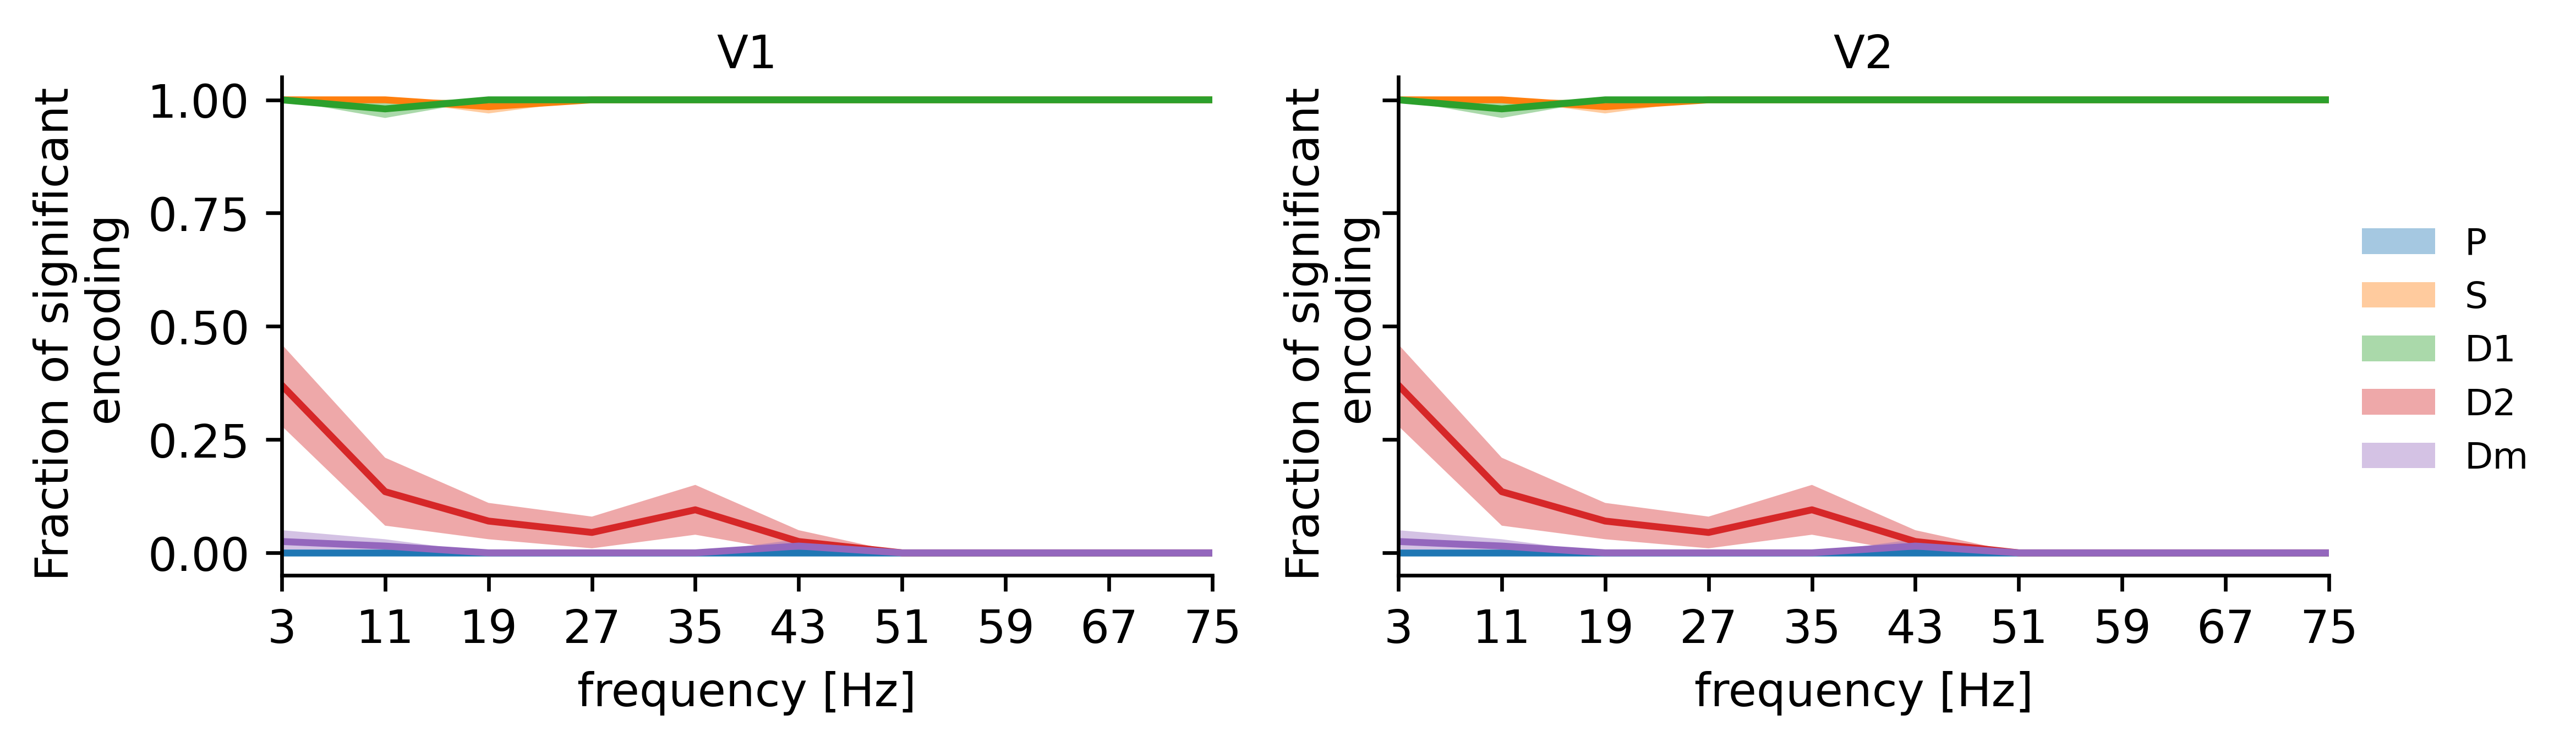

In [44]:
plt.figure(figsize=(8, 2), dpi=600)
ci = [ci_v1_noslvr, ci_v1_noslvr]
for pos in range(2):
    ax = plt.subplot(1, 2, pos + 1)
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        ax.legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(ax.get_yticklabels(), visible=False)

plt.savefig("figures/n3/figure7_slvr_ethyl.png")

In [167]:
overlap = np.logical_and((p_pow <= 0.001), (p_crk <= 0.001))

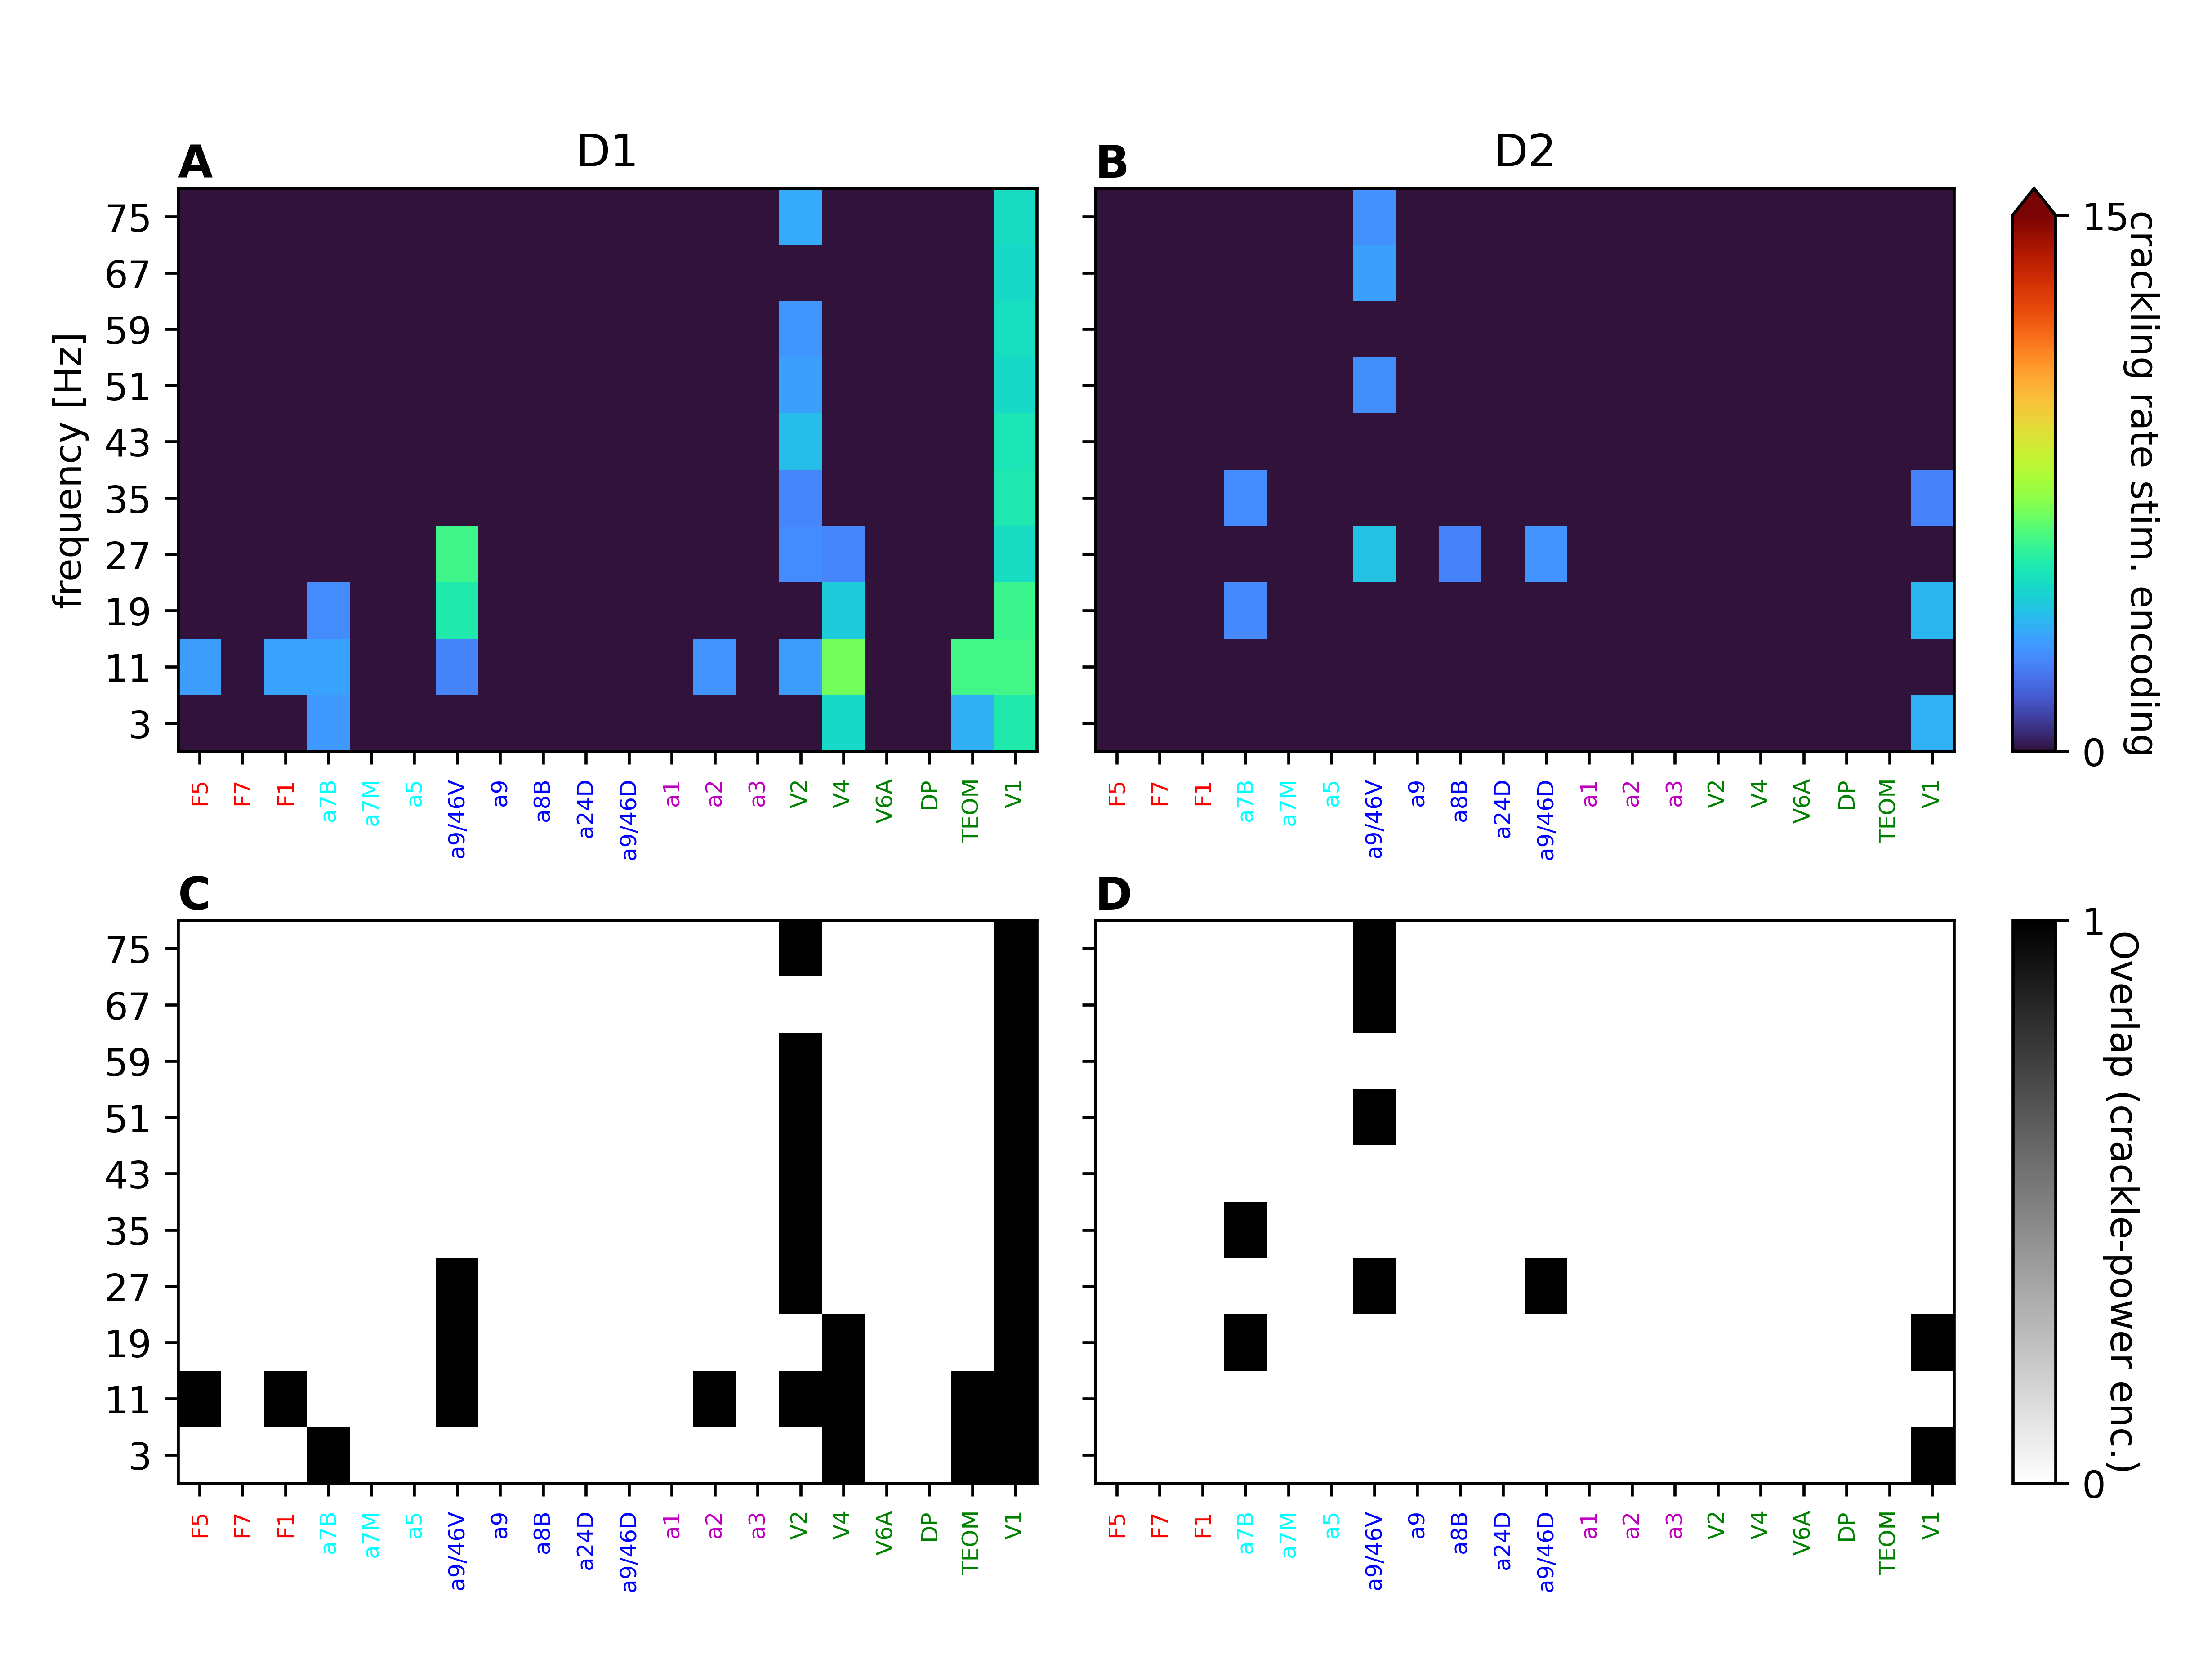

In [168]:
import matplotlib

fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=3,
    left=0.07,
    right=0.94,
    bottom=0.1,
    top=0.90,
    wspace=0.1,
    hspace=.3,
    width_ratios=(1, 1, 0.05),
)

axs0 = [plt.subplot(gs0[i]) for i in range(6)]

for i in range(2):
    plt.sca(axs0[i])
    plt.imshow(
        t_crk.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs0[1].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
cmap = matplotlib.cm.get_cmap("turbo")



cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 15],
    cax=axs0[2],
    extend="max",
)

cbar.ax.set_ylabel("crackling rate stim. encoding", rotation=270, labelpad=8)

##################################################################################################

for i in range(3, 5):
    plt.sca(axs0[i])
    plt.imshow(
        overlap.sel(times=i - 1).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=1,
        cmap="binary",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
plt.setp(axs0[4].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = matplotlib.cm.get_cmap("binary")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 1],
    cax=axs0[5],
    extend=None,
)


cbar.ax.set_ylabel("Overlap (crackle-power enc.)", rotation=270, labelpad=9)

bg = plot.Background(visible=False)

plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs0[1], axs0[3], axs0[4]],
    fontsize=12,
    xpos=[0, 0, 0, 0],
    ypos=[1.02, 1.02, 1.02, 1.02],
)

plt.savefig("figures/n3/figure8_ethyl.pdf")

In [144]:
def return_t_end(monkey):
    path = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/power")

    p_crk = node_xr_remove_sca(
        xr.load_dataarray(os.path.join(path, "pval_crackle_1_br_1_aligned_cue_q_90_fdr.nc"))
    )
    t_crk = node_xr_remove_sca(
        xr.load_dataarray(os.path.join(path, "tval_crackle_1_br_1_aligned_cue_q_90_fdr.nc"))
    )

    return t_crk, p_crk <= 0.001

In [145]:
tl, pl = return_t_end("lucy")
te, pe = return_t_end("ethyl")

In [146]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

rois = intersection(tl.roi.data, te.roi.data)

tl = tl.sel(roi=rois)
te = te.sel(roi=rois)

In [147]:
colors = np.asarray(["b", "r"])

idx = np.logical_and(pl, pe).astype(int)

In [148]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in rois])

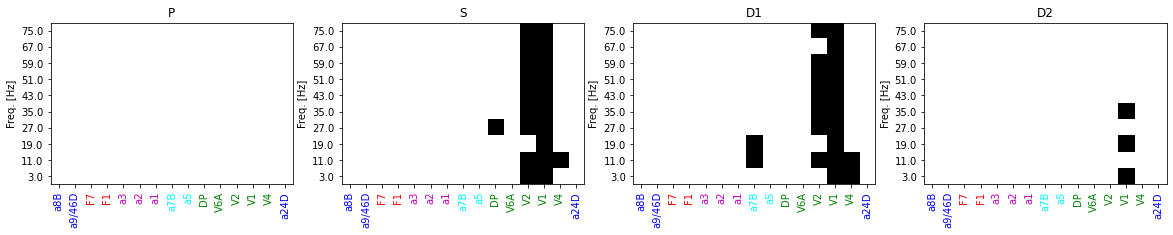

In [149]:
plt.figure(figsize=(20, 6))
for t in range(4):
    plt.subplot(1, 4, t + 1)
    plt.imshow(idx.sel(times=t), cmap="binary", origin="lower")
    tks = plt.xticks(range(len(rois)), rois, rotation=90)
    plt.yticks(range(10), tl.freqs.data);
    plt.title(f"{stage_labels[t]}")
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions)]
    plt.ylabel("Freq. [Hz]")